# MNIST classification

- https://en.wikipedia.org/wiki/MNIST_database

1. Naive-Bayes Classifier
    - skip. Less interesting. Maybe later.
2. Here we update input image thru SGD with the model, trained and fixed (not updated)
    - The result images look interesting, worth observing them to understand the model's capability.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn

print('numpy: ', np.__version__)
print('sklearn: ', sklearn.__version__)

numpy:  1.16.6
sklearn:  0.22.2.post1


## Dataset can be obtained directly from `torchvision`

In [2]:
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True)

len(mnist_train), len(mnist_test)

(60000, 10000)

### Returned are PIL Image and target label

<PIL.Image.Image image mode=L size=28x28 at 0x2A1D8DD4248> 5


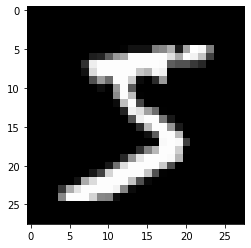

In [3]:
im, label = mnist_train[0]
plt.imshow(im, cmap='gray')
print(im, label)

### Convert to Tensor and A Custom torchvision.transformation for Binarization

In [4]:
class MyBinarization:
    """ convert a gray scale tensor [0, 1] to binary tensor of {0., 1.}"""
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def __call__(self, im):
        bright = im > self.threshold
        im[bright] = 1.
        im[~bright] = 0.
        return im

data_transform = torchvision.transforms.Compose([#transforms.Grayscale(), 
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda im: (im>0.5).float()), # another way to do binarizaiton
                                     #MyBinarization() ,
                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1)) # 
                                    ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

(torch.Size([784]), torch.float32, 5, array([0., 1.], dtype=float32), int, 784)

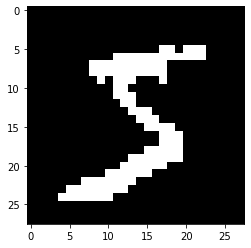

In [5]:
im, label = mnist_train[0]
plt.imshow(im.reshape(28,28), cmap='gray')
im.shape, im.dtype, label, np.unique(im), type(label), 28*28

## Bernoulli Naive Bayes
- https://github.com/dsgiitr/d2l-pytorch/blob/master/Ch04_The_Preliminaries_A_Crashcourse/Naive_Bayes_Classification.ipynb

In [6]:
xcount = torch.ones((im.reshape(-1).shape[0],10)).float()
ycount = torch.ones((10))

for im, label in mnist_train:
    xcount[:,label] += im.reshape(-1)
    ycount[label] += 1
#

In [7]:
py = ycount / ycount.sum()
px = xcount / ycount.unsqueeze(0) # each row is divided by ycount

- For example, px[300,:] shows the Bernoulli probability at the location 300 for the class labels.
- px[300,**k**] is the probability of being a bright pixel at the location 300 provided the class is **k**

In [8]:
px[300,:]

tensor([0.6437, 0.0114, 0.3167, 0.1797, 0.3377, 0.1046, 0.0781, 0.4349, 0.4508,
        0.3057])

Class Conditional Probabilities: 


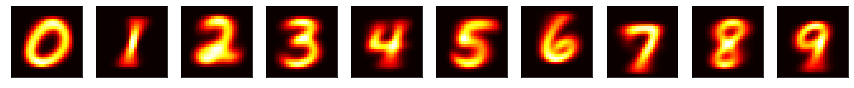

Class Prior Probabilities:
  tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])


In [9]:
fig, axes = plt.subplots(1,10, figsize=(15,10))
print('Class Conditional Probabilities: ')
for i in range(10):
    axes[i].imshow(px[:,i].reshape(28,28).numpy(), cmap='hot')
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()
print('Class Prior Probabilities:\n ', py)

* Notice that the images are well aligned within classes.

In [10]:
np.unique(mnist_train.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

## PyTorch Neural Network

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.utils
import torch.nn as nn
import torch.optim
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
print (device)

cuda:0


## Data Preparation

In [12]:
data_transform = torchvision.transforms.Compose([#transforms.Grayscale(), 
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1))
                                    ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

batch_size=4
data_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

torch.Size([784]) 5


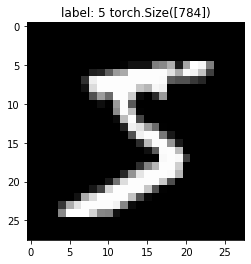

In [13]:
# Explore
im, label = mnist_train[0]

print(im.shape, label)
plt.imshow(im.reshape(28,28), cmap='gray')
plt.title(f'label: {label} {im.shape}');

torch.Size([4, 784])


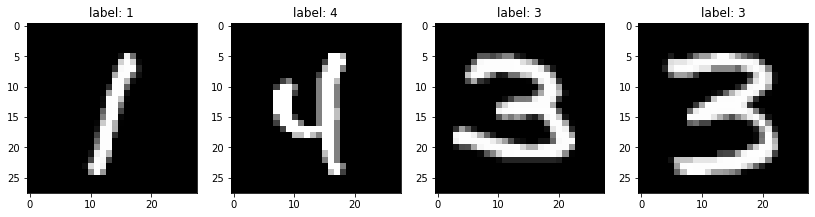

In [14]:
for batch_im, batch_label in data_loader_train:
    print(batch_im.shape)
    fig, axes = plt.subplots(1,batch_im.shape[0], figsize=(14,8))
    for i in range(batch_im.shape[0]):
        axes[i].imshow(batch_im[i].reshape(28,28), cmap='gray')
        axes[i].set_title(f'label: {batch_label[i]}')
    break

### Network Design

In [15]:
# Two hidden layer network

def myNetwork(in_features, n_targget):
    net = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=in_features//2),
        nn.Tanh(),
        nn.Linear(in_features=in_features//2, out_features=n_target),
        nn.LogSoftmax(dim=1)
        )
    return net
#

### Training Loop

In [16]:
import training_loop as tx

In [17]:
import importlib
importlib.reload(tx)

<module 'training_loop' from 'D:\\git\\gksg008\\training_loop.py'>

### Increase batch_size

In [18]:
batch_size=128
data_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

### optimizer & loss_function

In [19]:
in_features = 28*28
n_target=10
model = myNetwork(in_features, n_target).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss().to(device)

In [20]:
history = tx.training_loop(n_epochs=20,
                        optim=optimizer,
                        model=model,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test,
                        device=device
                        )

Epoch 1, tloss 1.45 vloss 0.84  t_acc: 0.72 v_acc: 0.83 | ellapsed: 6.8
Epoch 2, tloss 0.68 vloss 0.55  t_acc: 0.85 v_acc: 0.87 | ellapsed: 6.8333) --
Epoch 3, tloss 0.51 vloss 0.45  t_acc: 0.87 v_acc: 0.89 | ellapsed: 6.3
Epoch 4, tloss 0.44 vloss 0.40  t_acc: 0.88 v_acc: 0.89 | ellapsed: 6.2
Epoch 5, tloss 0.41 vloss 0.37  t_acc: 0.89 v_acc: 0.90 | ellapsed: 6.1
Epoch 20, tloss 0.29 vloss 0.28  t_acc: 0.92 v_acc: 0.92 | ellapsed: 6.16667) --
best model is loaded. finished training_loop().  / (tacc: 0.9176333333333333) --


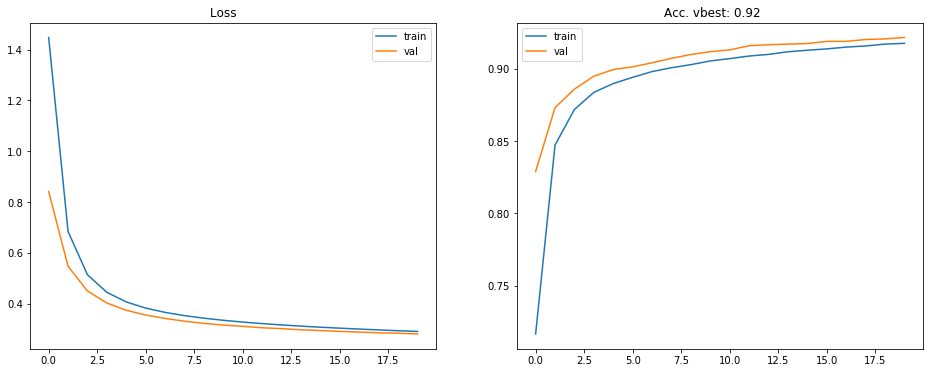

In [21]:
tx.plot_history(history)

## Now, the update is reversed. 
- model parameter is not updated. 
- the image input is updated starting from a random noise.
- the label of the image must be chosen so that the updated image comes to have a shape of the class corresponding to the label

In [22]:
model_file = 'mnist_model_ep20_vacc90.pth'
torch.save(model.state_dict(), model_file)

### load the weight file and verify

In [23]:
fixed_model = myNetwork(in_features, n_target).to(device)
fixed_model.load_state_dict(torch.load(model_file))
#
tx.performance(fixed_model, loss_fn, data_loader_test, device=device)

(0.2803316171646118, 0.9217)

### define variable to be updated

In [24]:
x = torch.rand(1,in_features).to(device).requires_grad_()

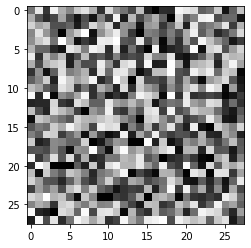

In [25]:
plt.imshow(x.detach().cpu().numpy()[0].reshape(28,28), cmap='gray')

In [26]:
label_tensor = torch.ones(1).long().to(device)
label_tensor = label_tensor * 0
label_tensor

tensor([0], device='cuda:0')

In [27]:
optimizer_x = torch.optim.SGD([x], lr=0.01)
loss_fn_x = nn.NLLLoss().to(device)

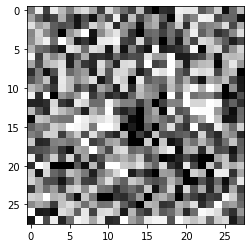

In [28]:
n_epochs=1000
for epoch in range(n_epochs):
    pred = fixed_model(x)
    loss = loss_fn_x(pred, label_tensor)
#    print(pred)
    optimizer_x.zero_grad()
    loss.backward()
    optimizer_x.step()
    
    x.data.clamp_(0., 1.)

#
plt.imshow(x[0].detach().cpu().numpy().reshape(28,28), cmap='gray')

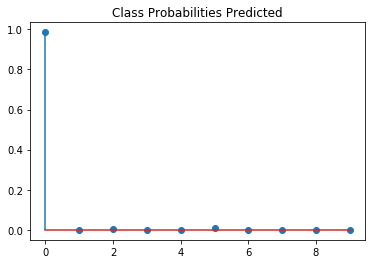

In [29]:
plt.stem(torch.exp(pred).detach().cpu().numpy().reshape(-1), use_line_collection=True)
plt.title('Class Probabilities Predicted');

## So, I decided to train the model more seriously!

Epoch 1, tloss 0.29 vloss 0.28  t_acc: 0.92 v_acc: 0.92 | ellapsed: 6.1
Epoch 2, tloss 0.28 vloss 0.28  t_acc: 0.92 v_acc: 0.92 | ellapsed: 6.1
Epoch 3, tloss 0.28 vloss 0.27  t_acc: 0.92 v_acc: 0.92 | ellapsed: 6.3
Epoch 4, tloss 0.28 vloss 0.27  t_acc: 0.92 v_acc: 0.92 | ellapsed: 6.26667) --
Epoch 5, tloss 0.28 vloss 0.27  t_acc: 0.92 v_acc: 0.92 | ellapsed: 6.33333) --
best model is loaded. finished training_loop(). 


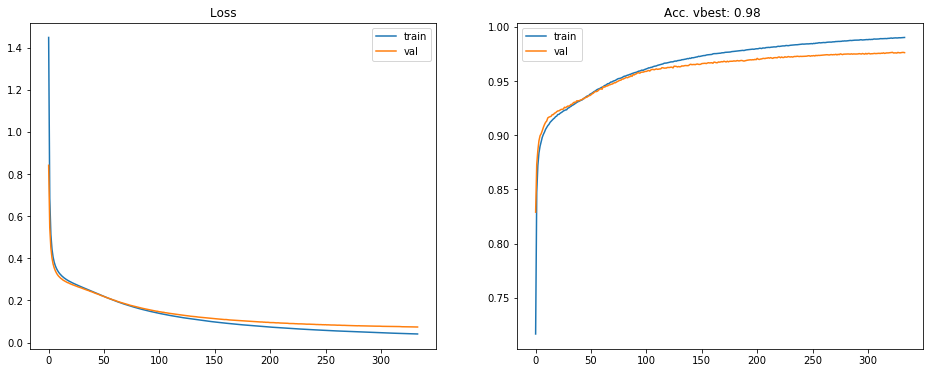

In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss().to(device)

history = tx.training_loop(n_epochs=500,
                        optim=optimizer,
                        model=model,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test,
                        hist=history,
                        device=device
                        )
tx.plot_history(history)

In [31]:
model_file = 'mnist_model_ep520_vacc90.pth'
torch.save(model.state_dict(), model_file)

fixed_model = myNetwork(in_features, n_target).to(device)
fixed_model.load_state_dict(torch.load(model_file))
#
tx.performance(fixed_model, loss_fn, data_loader_test, device=device)

(0.07551318302154542, 0.9765)

## Try again with Heavily Learned Model

In [32]:
x = torch.rand(10,in_features).to(device).requires_grad_()

In [33]:
def plot_all(x):
    fig, axes = plt.subplots(2,5, figsize=(16,7))
    for i, (ix, ax) in enumerate(zip(x, axes.flatten())):
        ax.set_title(f'{i}')
        ax.imshow(ix.detach().cpu().numpy().reshape(28,28), cmap='gray')

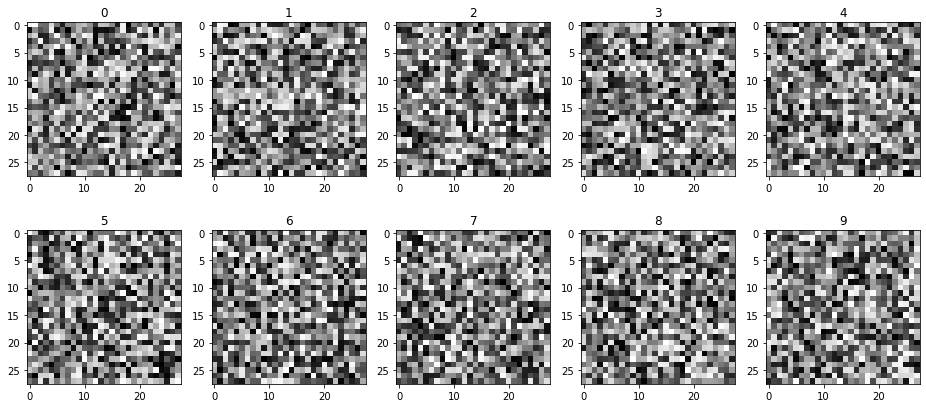

In [34]:
plot_all(x)

In [35]:
label_tensor = torch.arange(10).long().to(device)
label_tensor

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

In [36]:
optimizer_x = torch.optim.SGD([x], lr=0.01)
loss_fn_x = nn.NLLLoss().to(device)

prediction:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


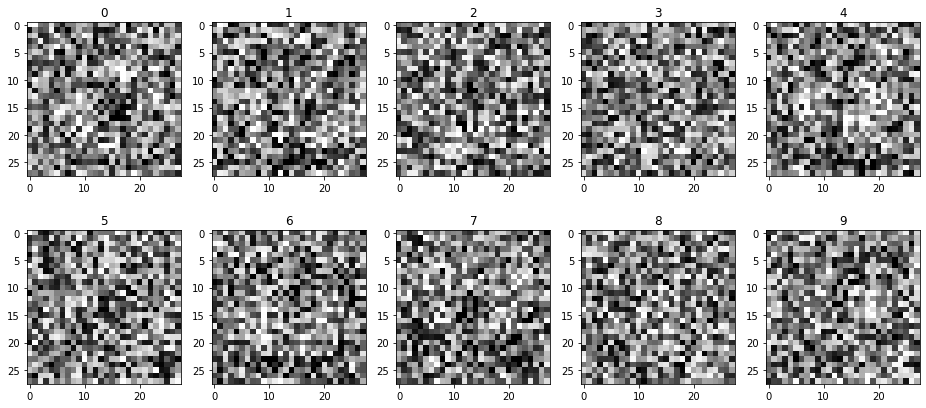

In [37]:
n_epochs=1000
for epoch in range(n_epochs):
    pred = fixed_model(x)
    loss = loss_fn_x(pred, label_tensor)
#    print(pred)
    optimizer_x.zero_grad()
    loss.backward()
    optimizer_x.step()
    
    x.data.clamp_(0., 1.)
#
print('prediction: ', torch.argmax(pred, dim=1))
#
plot_all(x)

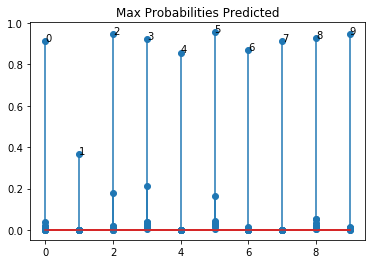

In [38]:
for i, p in enumerate(pred):
    prob = torch.exp(p).detach().cpu().numpy().reshape(-1)
    pmax = prob.max()
    pi = np.argmax(prob)
    plt.stem(prob, use_line_collection=True)
    plt.title('Max Probabilities Predicted');
    plt.annotate(f'{i}', xy=(pi, pmax))

---
## With Zero Initialization

In [39]:
x = torch.zeros(10, in_features).to(device).requires_grad_()

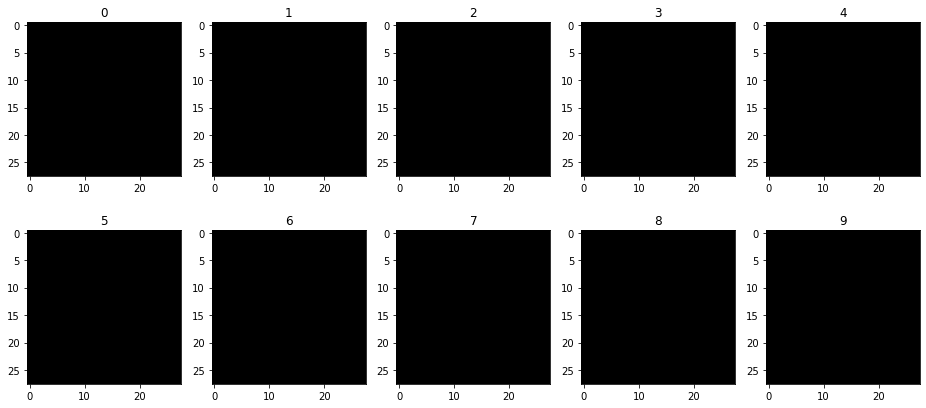

In [40]:
plot_all(x)

In [41]:
label_tensor = torch.arange(10).long().to(device)
label_tensor

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

In [42]:
optimizer_x = torch.optim.SGD([x], lr=0.01)
loss_fn_x = nn.NLLLoss().to(device)

prediction:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


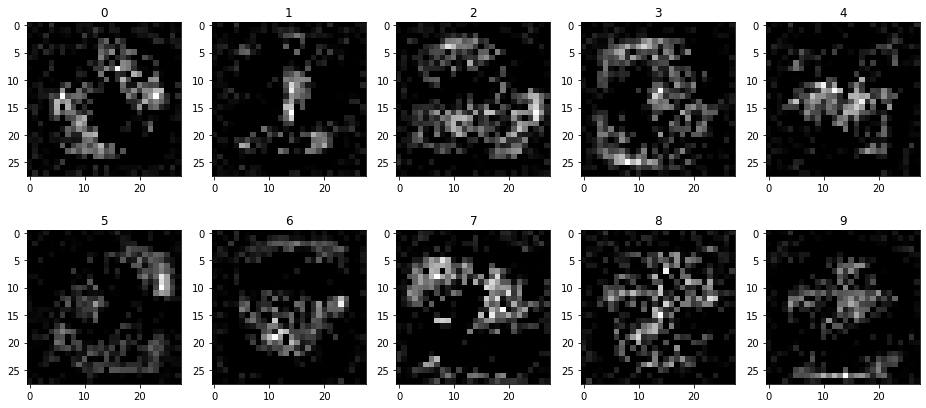

In [43]:
n_epochs=5000
for epoch in range(n_epochs):
    pred = fixed_model(x)
    loss = loss_fn_x(pred, label_tensor)
#    print(pred)
    optimizer_x.zero_grad()
    loss.backward()
    optimizer_x.step()
    
    x.data.clamp_(0., 1.)
#
print('prediction: ', torch.argmax(pred, dim=1))
#
plot_all(x)

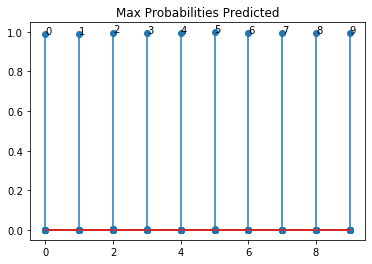

In [44]:
for i, p in enumerate(pred):
    prob = torch.exp(p).detach().cpu().numpy().reshape(-1)
    pmax = prob.max()
    pi = np.argmax(prob)
    plt.stem(prob, use_line_collection=True)
    plt.title('Max Probabilities Predicted');
    plt.annotate(f'{i}', xy=(pi, pmax))

---
## Initialization by One

In [45]:
x = torch.ones(10, in_features).to(device).requires_grad_()

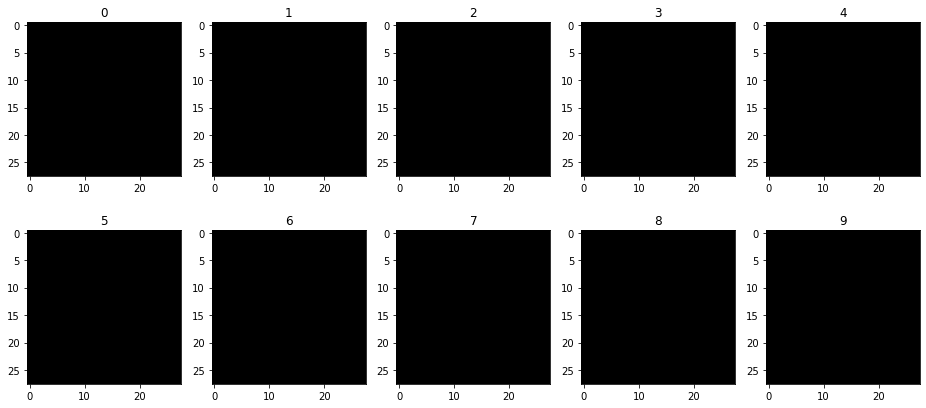

In [46]:
plot_all(x)

In [47]:
label_tensor = torch.arange(10).long().to(device)
label_tensor

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

In [48]:
optimizer_x = torch.optim.SGD([x], lr=0.01)
loss_fn_x = nn.NLLLoss().to(device)

prediction:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


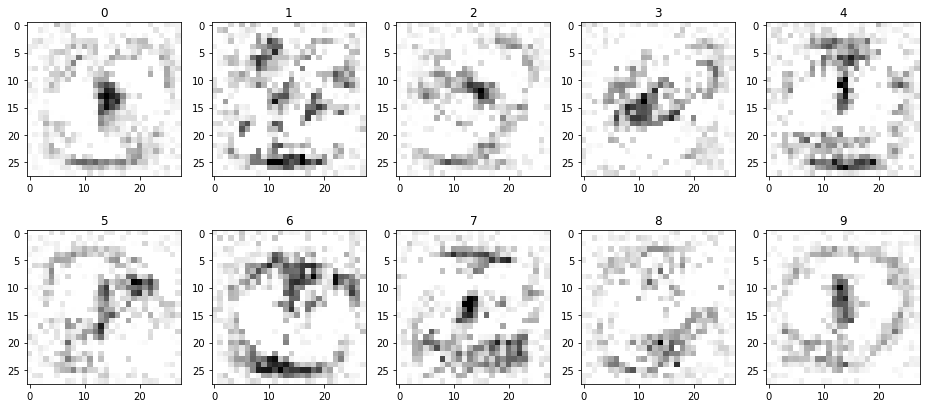

In [49]:
n_epochs=5000
for epoch in range(n_epochs):
    pred = fixed_model(x)
    loss = loss_fn_x(pred, label_tensor)
#    print(pred)
    optimizer_x.zero_grad()
    loss.backward()
    optimizer_x.step()
    
    x.data.clamp_(0., 1.)
#
print('prediction: ', torch.argmax(pred, dim=1))
#
plot_all(x)

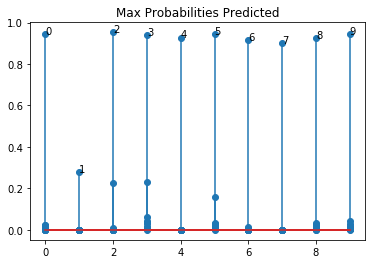

In [50]:
for i, p in enumerate(pred):
    prob = torch.exp(p).detach().cpu().numpy().reshape(-1)
    pmax = prob.max()
    pi = np.argmax(prob)
    plt.stem(prob, use_line_collection=True)
    plt.title('Max Probabilities Predicted');
    plt.annotate(f'{i}', xy=(pi, pmax))

---
## Initialization by Gaussian(0,1)

In [51]:
x = torch.randn(10, in_features).to(device).requires_grad_()
x.data.clamp_(0,1)

tensor([[1.0000, 0.0000, 0.3891,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.6614, 0.1658, 0.0000],
        [0.4608, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0072, 0.9093,  ..., 0.3500, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],
       device='cuda:0')

In [52]:
x

tensor([[1.0000, 0.0000, 0.3891,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.6614, 0.1658, 0.0000],
        [0.4608, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0072, 0.9093,  ..., 0.3500, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],
       device='cuda:0', requires_grad=True)

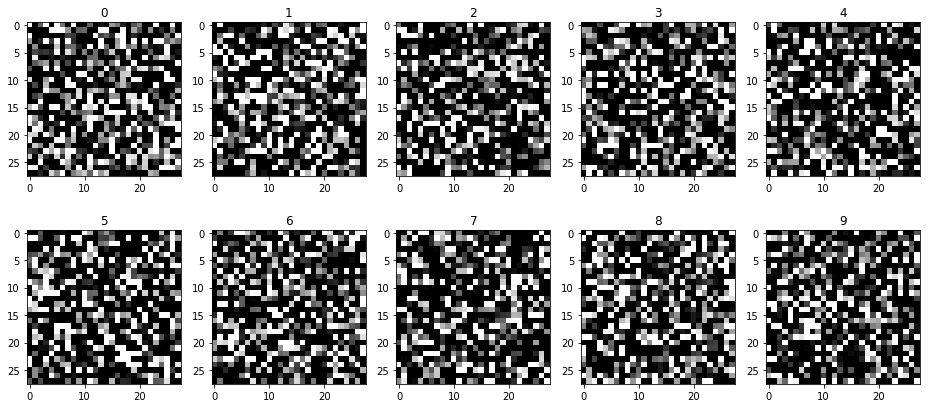

In [53]:
plot_all(x)

In [54]:
label_tensor = torch.arange(10).long().to(device)
label_tensor

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

In [55]:
optimizer_x = torch.optim.SGD([x], lr=0.01)
loss_fn_x = nn.NLLLoss().to(device)

prediction:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


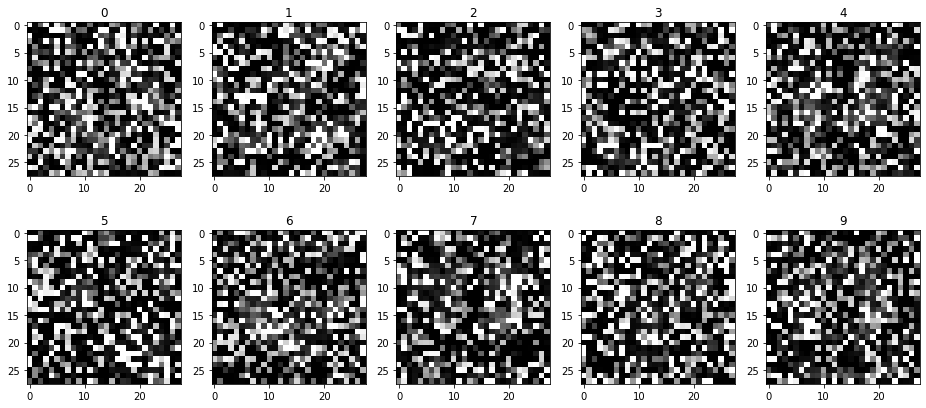

In [56]:
n_epochs=5000
for epoch in range(n_epochs):
    pred = fixed_model(x)
    loss = loss_fn_x(pred, label_tensor)
#    print(pred)
    optimizer_x.zero_grad()
    loss.backward()
    optimizer_x.step()
    
    x.data.clamp_(0., 1.)
#
print('prediction: ', torch.argmax(pred, dim=1))
#
plot_all(x)

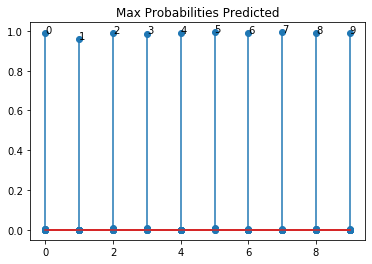

In [57]:
for i, p in enumerate(pred):
    prob = torch.exp(p).detach().cpu().numpy().reshape(-1)
    pmax = prob.max()
    pi = np.argmax(prob)
    plt.stem(prob, use_line_collection=True)
    plt.title('Max Probabilities Predicted');
    plt.annotate(f'{i}', xy=(pi, pmax))

---
## Initialization by 0.5

In [58]:
x = torch.ones(10, in_features).to(device).requires_grad_() 
x.data *= 0.5

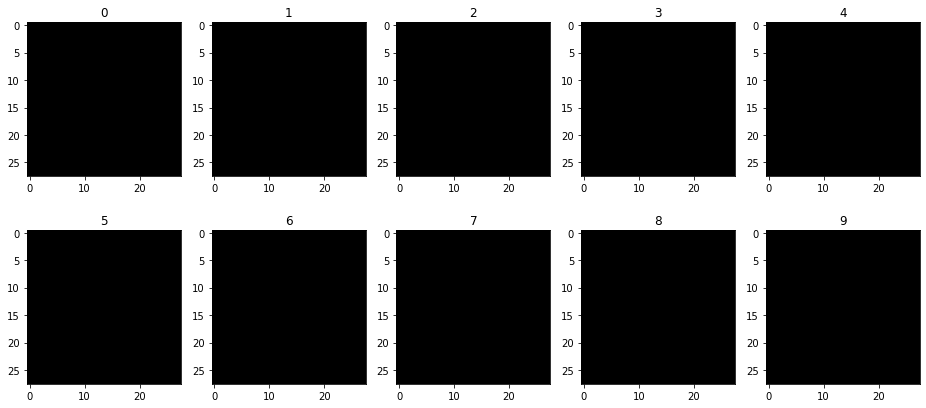

In [59]:
plot_all(x)

In [60]:
x

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       device='cuda:0', requires_grad=True)

In [61]:
label_tensor = torch.arange(10).long().to(device)
label_tensor

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

In [62]:
optimizer_x = torch.optim.SGD([x], lr=0.01)
loss_fn_x = nn.NLLLoss().to(device)

prediction:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


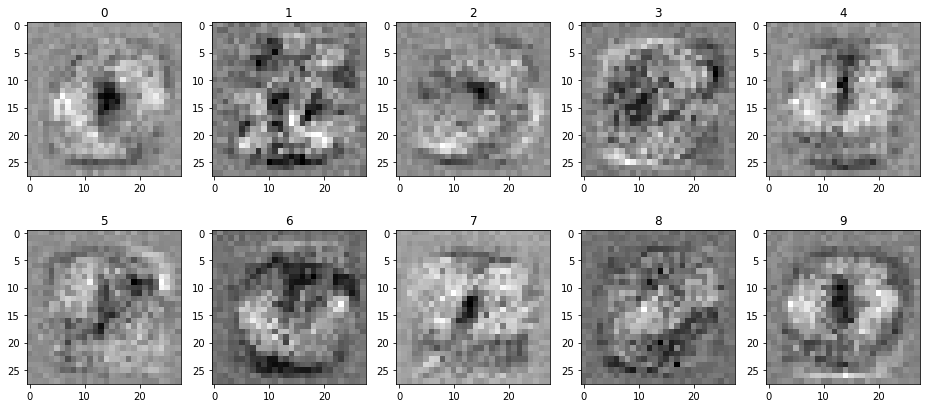

In [63]:
n_epochs=5000
for epoch in range(n_epochs):
    pred = fixed_model(x)
    loss = loss_fn_x(pred, label_tensor)
#    print(pred)
    optimizer_x.zero_grad()
    loss.backward()
    optimizer_x.step()
    
    x.data.clamp_(0., 1.)
#
print('prediction: ', torch.argmax(pred, dim=1))
#
plot_all(x)

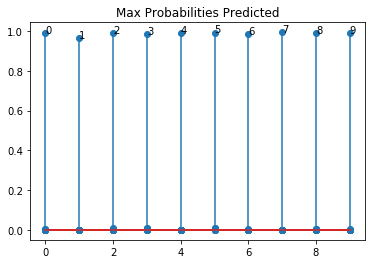

In [64]:
for i, p in enumerate(pred):
    prob = torch.exp(p).detach().cpu().numpy().reshape(-1)
    pmax = prob.max()
    pi = np.argmax(prob)
    plt.stem(prob, use_line_collection=True)
    plt.title('Max Probabilities Predicted');
    plt.annotate(f'{i}', xy=(pi, pmax))

---
## Initialization by Bernoulli(p=0.5)

In [65]:
bernoulli = torch.distributions.bernoulli.Bernoulli(probs=0.5)
bernoulli.sample(sample_shape=(1,10))

tensor([[1., 1., 0., 1., 1., 0., 0., 1., 0., 0.]])

In [66]:
x = bernoulli.sample(sample_shape=(10, in_features)).to(device).requires_grad_()

In [67]:
x

tensor([[1., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 0.],
        [1., 1., 0.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 1.]], device='cuda:0', requires_grad=True)

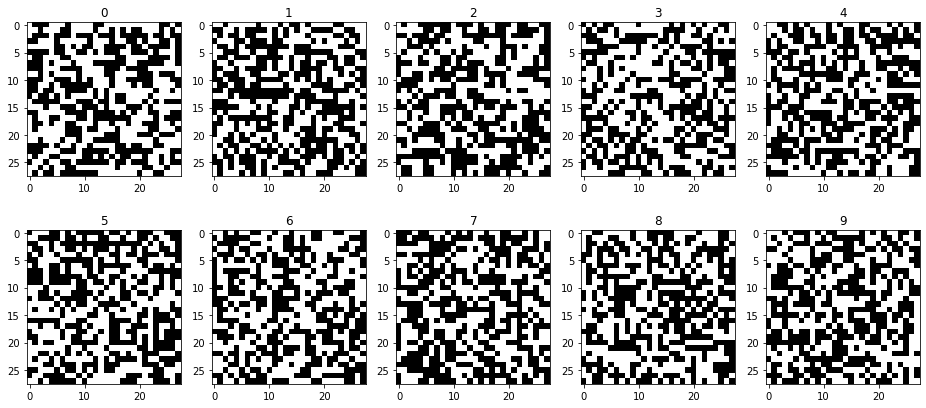

In [68]:
plot_all(x)

In [69]:
label_tensor = torch.arange(10).long().to(device)
label_tensor

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

In [70]:
optimizer_x = torch.optim.SGD([x], lr=0.01)
loss_fn_x = nn.NLLLoss().to(device)

prediction:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


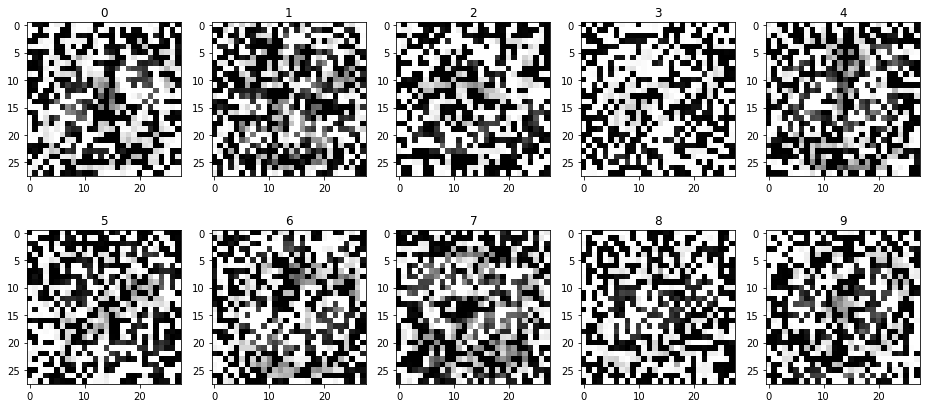

In [71]:
n_epochs=5000
for epoch in range(n_epochs):
    pred = fixed_model(x)
    loss = loss_fn_x(pred, label_tensor)
#    print(pred)
    optimizer_x.zero_grad()
    loss.backward()
    optimizer_x.step()
    
    x.data.clamp_(0., 1.)
#
print('prediction: ', torch.argmax(pred, dim=1))
#
plot_all(x)

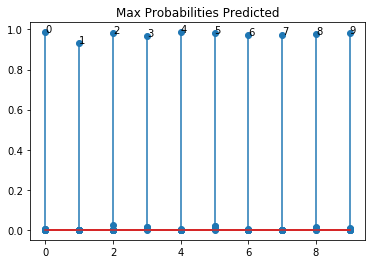

In [72]:
for i, p in enumerate(pred):
    prob = torch.exp(p).detach().cpu().numpy().reshape(-1)
    pmax = prob.max()
    pi = np.argmax(prob)
    plt.stem(prob, use_line_collection=True)
    plt.title('Max Probabilities Predicted');
    plt.annotate(f'{i}', xy=(pi, pmax))

## Summary
- The inputs that can be recognized by a trained network may be much more diverse than we may simply imagine.
- This result will be different if the architechture is changed.
- Is this a problem? Provide your opinion.

### Practicum
- Repeat the same experiments with a convolution network model

---
End.